<a href="https://colab.research.google.com/github/Chaelsy-kim/Capstone_Design/blob/main/Resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

import matplotlib.pyplot as plt
import numpy as np

import copy
from collections import namedtuple
import os
import random
import time

import cv2
from torch.utils.data import DataLoader, Dataset
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [46]:
# 데이터셋을 불러오고, 훈련/테스트/검증 셋으로 분리
metal_train = '/content/drive/MyDrive/dataset/train/metal/'
wood_train = '/content/drive/MyDrive/dataset/train/wood/'
metal_test='/content/drive/MyDrive/dataset/test/metal'
wood_test='/content/drive/MyDrive/dataset/test/wood'
metal_valid='/content/drive/MyDrive/dataset/valid/metal'
wood_valid='/content/drive/MyDrive/dataset/valid/wood'

metal_train_filepath = sorted([os.path.join(metal_train, f) for f in os.listdir(metal_train)])
wood_train_filepath = sorted([os.path.join(wood_train, f) for f in os.listdir(wood_train)])
metal_test_filepath = sorted([os.path.join(metal_test, f) for f in os.listdir(metal_test)])
wood_test_filepath = sorted([os.path.join(wood_test, f) for f in os.listdir(wood_test)])
metal_valid_filepath = sorted([os.path.join(metal_valid, f) for f in os.listdir(metal_valid)])
wood_valid_filepath = sorted([os.path.join(wood_valid, f) for f in os.listdir(wood_valid)])

train_filepaths = [*metal_train_filepath, *wood_train_filepath]
test_filepaths = [*metal_test_filepath, *wood_test_filepath]
val_filepaths = [*metal_valid_filepath, *wood_valid_filepath]


print(len(train_filepaths), len(val_filepaths), len(test_filepaths))

1050 90 20


In [47]:
# 이미지 데이터 전처리
class ImageTransform() :
    def __init__(self, resize, mean, std) :
        self.data_transform = {
            'train' : transforms.Compose([
                    transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize(mean, std)
            ]),
            'val' : transforms.Compose([
                    transforms.Resize(256),
                    transforms.CenterCrop(resize),
                    transforms.ToTensor(),
                    transforms.Normalize(mean, std)
            ])
        }
        
    def __call__(self, img, phase) :
        return self.data_transform[phase](img)

In [48]:
# 변수 값을 정의
size = 256
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32

In [49]:
# 이미지 레이블을 구분
class MetalvsWoodDataset(Dataset) :
    def __init__(self, file_list, transform=None, phase='train') :
        self.file_list = file_list
        self.transform = transform
        self.phase = phase
        
    def __len__(self) :
        return len(self.file_list)
    
    def __getitem__(self, idx) :
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img, self.phase)
        
        label = img_path.split('/')[-2]
        if label == 'metal' :
            label = 1
        elif label == 'wood' :
            label = 0
            
        return img_transformed, label

In [50]:
# 이미지 데이터셋을 정의
train_dataset = MetalvsWoodDataset(train_filepaths, transform=ImageTransform(size, mean, std),
                               phase='train')
val_dataset = MetalvsWoodDataset(val_filepaths, transform=ImageTransform(size, mean, std),
                             phase='val')
test_dataset =MetalvsWoodDataset(test_filepaths, transform=ImageTransform(size, mean, std),
                            phase='test')

index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

torch.Size([3, 256, 256])
1


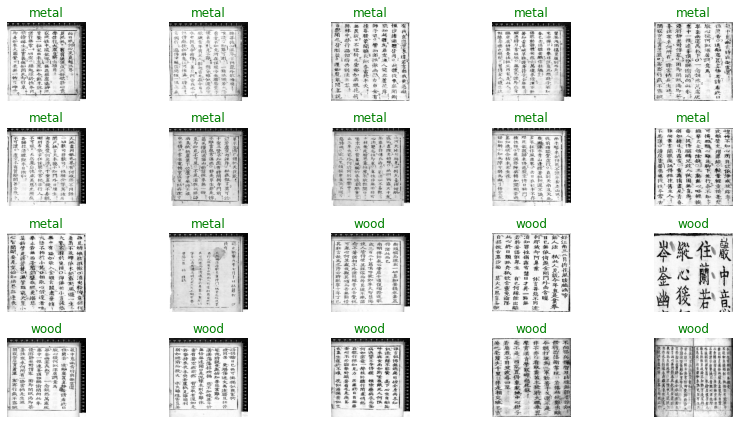

In [51]:
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        true_label = os.path.normpath(image_filepath).split(os.sep)[-2]
        predicted_label = predicted_labels[i] if predicted_labels else true_label
        color = "green" if true_label == predicted_label else "red"
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(predicted_label, color=color)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()
display_image_grid(test_filepaths)

In [52]:
# 이미지 데이터 불러오기
train_iterator = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_iterator = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_iterator = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
dataloader_dict = {'train' : train_iterator, 'val' : valid_iterator}

batch_iterator = iter(train_iterator)
inputs, label = next(batch_iterator)
print(inputs.size())
print(label)

torch.Size([32, 3, 256, 256])
tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
        0, 0, 0, 1, 1, 1, 1, 1])


기본 블록(basicBlock)을 정의한다. 다운샘플은 입력 데이터의 크기와 네트워크를 통과한 출력 데이터 크기가 다를 경우에 사용한다. 다운샘플을 하기 위해서는 합성곱에 스트라이드를 적용한다. 아이덴티티 매핑을 적용한다. 특정 층에 존재하는 출력 결과를 다음 합성곱층을 통과한 출력 결과에 더해 주는 작업(=skip connection)이다(shortcut 이라고도 함).

In [53]:
class BasicBlock(nn.Module):    
    expansion = 1
    
    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()                
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, 
                               stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                               stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)        
        self.relu = nn.ReLU(inplace = True)
        
        if downsample:
            conv = nn.Conv2d(in_channels, out_channels, kernel_size = 1, 
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None        
        self.downsample = downsample
        
    def forward(self, x):       
        i = x       
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)        
        x = self.conv2(x)
        x = self.bn2(x)
        
        if self.downsample is not None:
            i = self.downsample(i)
                        
        x += i
        x = self.relu(x)
        
        return x

병목 블록을 정의한다. 
병목 블록은 ResNet50, ResNet101, ResNet152에서 사용되며, 1X1 합성곱층, 3X3 합성곱층, 1X1 합성곱층으로 구성된다. 
(기본 블록은 3X3 합성곱층 두 개를 갖는다.)

In [54]:
class Bottleneck(nn.Module):    
    expansion = 4
    
    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()    
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 1, stride = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = stride, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)        
        self.conv3 = nn.Conv2d(out_channels, self.expansion * out_channels, kernel_size = 1,
                               stride = 1, bias = False)
        self.bn3 = nn.BatchNorm2d(self.expansion * out_channels)        
        self.relu = nn.ReLU(inplace = True)
        
        if downsample:
            conv = nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size = 1, 
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(self.expansion * out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None            
        self.downsample = downsample
        
    def forward(self, x):        
        i = x        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)        
        x = self.conv3(x)
        x = self.bn3(x)
                
        if self.downsample is not None:
            i = self.downsample(i)
            
        x += i
        x = self.relu(x)
    
        return x

In [55]:
# ResNet 네트워크를 정의
class ResNet(nn.Module):
    def __init__(self, config, output_dim, zero_init_residual=False):
        super().__init__()
                
        block, n_blocks, channels = config
        self.in_channels = channels[0]            
        assert len(n_blocks) == len(channels) == 4
        
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size = 7, stride = 2, padding = 3, bias = False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace = True)
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        
        self.layer1 = self.get_resnet_layer(block, n_blocks[0], channels[0])
        self.layer2 = self.get_resnet_layer(block, n_blocks[1], channels[1], stride = 2)
        self.layer3 = self.get_resnet_layer(block, n_blocks[2], channels[2], stride = 2)
        self.layer4 = self.get_resnet_layer(block, n_blocks[3], channels[3], stride = 2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(self.in_channels, output_dim)

        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)
        
    def get_resnet_layer(self, block, n_blocks, channels, stride = 1):   
        layers = []        
        if self.in_channels != block.expansion * channels:
            downsample = True
        else:
            downsample = False
        
        layers.append(block(self.in_channels, channels, stride, downsample))
        
        for i in range(1, n_blocks):
            layers.append(block(block.expansion * channels, channels))

        self.in_channels = block.expansion * channels            
        return nn.Sequential(*layers)
        
    def forward(self, x):        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)        
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.fc(h)        
        return x, h

In [56]:
ResNetConfig = namedtuple('ResNetConfig', ['block', 'n_blocks', 'channels'])

In [57]:
# 기본 블록을 사용하는 resnet의 config를 정의
resnet18_config = ResNetConfig(block = BasicBlock,
                               n_blocks = [2,2,2,2],
                               channels = [64, 128, 256, 512])

resnet34_config = ResNetConfig(block = BasicBlock,
                               n_blocks = [3,4,6,3],
                               channels = [64, 128, 256, 512])

In [58]:
# 병목 블록을 사용하는 resnet의 config를 정의
resnet50_config = ResNetConfig(block = Bottleneck,
                               n_blocks = [3, 4, 6, 3],
                               channels = [64, 128, 256, 512])

resnet101_config = ResNetConfig(block = Bottleneck,
                                n_blocks = [3, 4, 23, 3],
                                channels = [64, 128, 256, 512])

resnet152_config = ResNetConfig(block = Bottleneck,
                                n_blocks = [3, 8, 36, 3],
                                channels = [64, 128, 256, 512])

In [59]:
# 사전 훈련된 ResNet을 로드 및 확인
pretrained_model = models.resnet50(pretrained = True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [60]:
print(pretrained_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [61]:
# ResNet50을 사용
OUTPUT_DIM = 2
model = ResNet(resnet50_config, OUTPUT_DIM)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [62]:
# optimizer와 loss function을 정의
optimizer = optim.Adam(model.parameters(), lr=1e-7)
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [63]:
# 모델의 정확도 측정함수를 정의
def calculate_topk_accuracy(y_pred, y, k = 2):
    with torch.no_grad():
        batch_size = y.shape[0]
        _, top_pred = y_pred.topk(k, 1)
        top_pred = top_pred.t()
        correct = top_pred.eq(y.view(1, -1).expand_as(top_pred))
        correct_1 = correct[:1].reshape(-1).float().sum(0, keepdim = True)
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim = True)
        acc_1 = correct_1 / batch_size
        acc_k = correct_k / batch_size
    return acc_1, acc_k

In [64]:
# 모델의 학습 함수를 정의
def train(model, iterator, optimizer, criterion, device):    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.train()    
    for (x, y) in iterator:        
        x = x.to(device)
        y = y.to(device)
            
        optimizer.zero_grad()                
        y_pred = model(x)  
        
        loss = criterion(y_pred[0], y) 
        
        acc_1, acc_5 = calculate_topk_accuracy(y_pred[0], y)        
        loss.backward()        
        optimizer.step()        
        
        epoch_loss += loss.item()
        epoch_acc_1 += acc_1.item()
        epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)        
    return epoch_loss, epoch_acc_1, epoch_acc_5

In [65]:
# 모델 평가 함수를 정의
def evaluate(model, iterator, criterion, device):    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.eval()    
    with torch.no_grad():        
        for (x, y) in iterator:
            x = x.to(device)
            y = y.to(device)
            y_pred = model(x)            
            loss = criterion(y_pred[0], y)
            acc_1, acc_5 = calculate_topk_accuracy(y_pred[0], y)

            epoch_loss += loss.item()
            epoch_acc_1 += acc_1.item()
            epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)        
    return epoch_loss, epoch_acc_1, epoch_acc_5

In [66]:
# 모델을 학습
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [67]:
best_valid_loss = float('inf')
EPOCHS = 10

for epoch in range(EPOCHS):    
    start_time = time.monotonic()
    
    train_loss, train_acc_1, train_acc_5 = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc_1, valid_acc_5 = evaluate(model, valid_iterator, criterion, device)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'ResNet-model.pt')

    end_time = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}% | ' \
          f'Train Acc @5: {train_acc_5*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc @1: {valid_acc_1*100:6.2f}% | ' \
          f'Valid Acc @5: {valid_acc_5*100:6.2f}%')

Epoch: 01 | Epoch Time: 0m 27s
	Train Loss: 0.756 | Train Acc @1:  48.56% | Train Acc @5: 100.00%
	Valid Loss: 0.796 | Valid Acc @1:  41.67% | Valid Acc @5: 100.00%
Epoch: 02 | Epoch Time: 0m 26s
	Train Loss: 0.750 | Train Acc @1:  48.53% | Train Acc @5: 100.00%
	Valid Loss: 0.781 | Valid Acc @1:  41.67% | Valid Acc @5: 100.00%
Epoch: 03 | Epoch Time: 0m 27s
	Train Loss: 0.744 | Train Acc @1:  48.72% | Train Acc @5: 100.00%
	Valid Loss: 0.772 | Valid Acc @1:  42.71% | Valid Acc @5: 100.00%
Epoch: 04 | Epoch Time: 0m 26s
	Train Loss: 0.743 | Train Acc @1:  48.51% | Train Acc @5: 100.00%
	Valid Loss: 0.770 | Valid Acc @1:  42.71% | Valid Acc @5: 100.00%
Epoch: 05 | Epoch Time: 0m 26s
	Train Loss: 0.742 | Train Acc @1:  48.63% | Train Acc @5: 100.00%
	Valid Loss: 0.768 | Valid Acc @1:  44.79% | Valid Acc @5: 100.00%
Epoch: 06 | Epoch Time: 0m 26s
	Train Loss: 0.737 | Train Acc @1:  48.89% | Train Acc @5: 100.00%
	Valid Loss: 0.752 | Valid Acc @1:  46.07% | Valid Acc @5: 100.00%
Epoch: 07 

In [68]:
# 테스트 데이터셋으로 모델을 예측
import pandas as pd
id_list = []
pred_list = []
_id=0
with torch.no_grad():
    for test_path in test_filepaths:
        img = Image.open(test_path)
        _id =test_path.split('/')[-1].split('.')[1]
        transform = ImageTransform(size, mean, std)
        img = transform(img, phase='val')
        img = img.unsqueeze(0)
        img = img.to(device)

        model.eval()
        outputs = model(img)
        preds = F.softmax(outputs[0], dim=1)[:, 1].tolist()        
        id_list.append(_id)
        pred_list.append(preds[0])
       
res = pd.DataFrame({
    'id': id_list,
    'label': pred_list
})

res.sort_values(by='id', inplace=True)
res.reset_index(drop=True, inplace=True)

res.to_csv('ReNet.csv', index=False)
res.head(10)

,id,label
0,rf,0.614170
1,rf,0.555218
2,rf,0.659118
3,rf,0.660358
4,rf,0.385643
5,rf,0.455718
6,rf,0.660869
7,rf,0.710747
8,rf,0.519902
9,rf,0.575390


In [69]:
def display_img_grid(img_filepath, cols=5) :
    rows = len(img_filepath) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, img_filepath in enumerate(img_filepath) :
        image = cv2.imread(img_filepath)
        true_label = os.path.normpath(img_filepath).split(os.sep)[-2] 
        pred_label = res.loc[i,'label']
        if pred_label > 0.5 :
            pred_label = 'metal'
        else :
            pred_label = 'wood'
        color = 'green' if true_label == pred_label else 'red'
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(pred_label, color=color)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

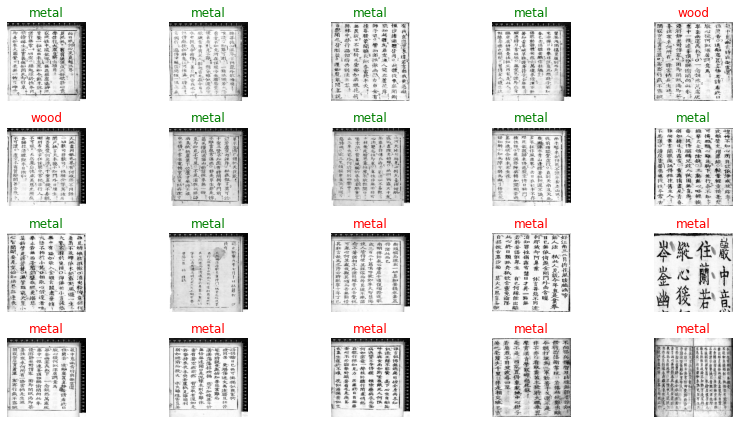

In [70]:
display_img_grid(test_filepaths)